In [2]:
import pandas as pd

df = pd.read_excel("/home/jbetancur/Desktop/codes/clustering/patients_with_qsm.xlsx")
df.head()

,PatientID,FolderType
0,16884118,baseline
1,10844214,baseline
2,11638211,baseline
3,341862,baseline
4,18110844,baseline


In [1]:
import nibabel as nib

img = nib.load('/home/jbetancur/Desktop/codes/python_qsm/exploratory_pipeline/data_automatization/clean_baseline/136646/2023/registered/mag_canonical.nii.gz')

data = img.get_fdata()
print("Image shape:", data.shape)
print("Affine matrix:\n", img.affine)



Image shape: (176, 232, 256)
Affine matrix:
 [[ 9.93385196e-01  5.85977770e-02  9.83016938e-02 -1.17887924e+02]
 [-5.83103634e-02  9.98281658e-01 -5.77017944e-03 -1.01216362e+02]
 [-9.84664559e-02  6.98793745e-10  9.95139956e-01 -1.51915665e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [2]:
import numpy as np

# Get the direction vectors for each axis
directions = img.affine[:3, :3]
# Find which axis has the largest component in the Z direction
slice_axis = np.argmax(np.abs(directions[2]))
print(f"Slice axis (0=X, 1=Y, 2=Z): {slice_axis}")


Slice axis (0=X, 1=Y, 2=Z): 2


# CHecking new pyradiomic features

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
csv_path = "/home/jbetancur/Desktop/codes/clustering/feature_extraction/output/final_radiomic_qsm_wavelet_2d_3d.csv"
df = pd.read_csv(csv_path)
pd.set_option('display.max_columns', None)
print(f"Data shape: {df.shape}")
df.head()

Data shape: (5, 3399)


label_id  num_voxels  volume_physical  T1_3d_original_shape_Elongation  \
0         5         196       196.010907                         0.803015   
1         7          83        83.004619                         0.634230   
2         8          12        12.000668                         0.612372   
3        10         118       118.006566                         0.619436   
4        12          13        13.000723                         0.548477   

   T1_3d_original_shape_Flatness  T1_3d_original_shape_LeastAxisLength  \
0                       0.623114                              5.213047   
1                       0.549190                              3.867508   
2                       0.612372                              2.000000   
3                       0.524897                              4.236391   
4                       0.000000                              0.000000   

   T1_3d_original_shape_MajorAxisLength  \
0                              8.366125   
1                              7.042205   
2                              3.265986   
3                              8.070896   
4                              5.327693   

   T1_3d_original_shape_Maximum2DDiameterColumn  \
0                                      8.944272   
1                                      7.211103   
2                                      2.236068   
3                                      6.708204   
4                                      5.385165   

   T1_3d_original_shape_Maximum2DDiameterRow  \
0                                   9.433981   
1                                   5.385165   
2                                   3.162278   
3                                   8.602325   
4                                   5.000000   

   T1_3d_original_shape_Maximum2DDiameterSlice  \
0                                     8.062258   
1                                     6.708204   
2                                     3.162278   
3                                     7.615773   
4                                     3.000000   

   T1_3d_original_shape_Maximum3DDiameter  T1_3d_original_shape_MeshVolume  \
0                                9.643651                       188.833333   
1                                7.810250                        77.291667   
2                                3.316625                         9.166667   
3                                9.110434                       111.625000   
4                                5.385165                         9.666667   

   T1_3d_original_shape_MinorAxisLength  T1_3d_original_shape_Sphericity  \
0                              6.718126                         0.847684   
1                              4.466375                         0.820017   
2                              2.000000                         0.919110   
3                              4.999407                         0.842991   
4                              2.922116                         0.719275   

   T1_3d_original_shape_SurfaceArea  T1_3d_original_shape_SurfaceVolumeRatio  \
0                        187.774165                                 0.994391   
1                        107.008039                                 1.384471   
2                         23.045759                                 2.514083   
3                        132.995020                                 1.191445   
4                         30.509861                                 3.156193   

   T1_3d_original_shape_VoxelVolume  T1_3d_original_firstorder_10Percentile  \
0                             196.0                              235.576210   
1                              83.0                              263.412433   
2                              12.0                              295.853317   
3                             118.0                              256.538425   
4                              13.0                              210.105258   

   T1_3d_original_firstorder_90Percentile  T1_3d_original

In [4]:
print(df.dtypes.value_counts())

float64    2554
int64         4
object        4
Name: count, dtype: int64


In [5]:
# count NaNs per column
nan_counts = df.isna().sum()
nan_cols   = nan_counts[nan_counts > 0].sort_values(ascending=False)
print("Columns with missing values:")
print(nan_cols)

Columns with missing values:
Series([], dtype: int64)


In [6]:
# Error columns summary
error_cols = [c for c in df.columns if c.endswith("_error")]
print("Error columns found:", error_cols)

Error columns found: ['T1_2d_error', 'T2_2d_error', 'QSM_2d_error']


In [7]:
# how many lesions actually hit each error
for col in error_cols:
    n = df[col].notna().sum()
    if n:
        print(f"  – {col}: {n} lesions")

  – T1_2d_error: 65 lesions
  – T2_2d_error: 65 lesions
  – QSM_2d_error: 65 lesions


In [9]:
# Constant (zero‐variance) features
# Features that never change are not informative and often indicate a filter didn’t run.
numeric = df.select_dtypes(include=[np.number])
zero_var = numeric.std().loc[lambda x: x == 0]
print("Zero‐variance numeric columns (constant):")
print(zero_var.index.tolist())

Zero‐variance numeric columns (constant):
[]


In [10]:
# Wavelet feature presence
wavelet_cols = [c for c in df.columns if "wavelet" in c.lower()]
print(f"Total wavelet‐derived columns: {len(wavelet_cols)}")
print("Example wavelet columns:", wavelet_cols[:10])

Total wavelet‐derived columns: 0
Example wavelet columns: []


In [11]:
# 2D vs 3D feature coverage
# If you see “Wrong dimensionality” warnings, the 3D extractor may have dropped some features;
# here we check how many NaNs appear in 2D vs 3D sets.
cols_3d = [c for c in df.columns if "_3d_" in c and not c.endswith("_error")]
cols_2d = [c for c in df.columns if "_2d_" in c and not c.endswith("_error")]

nan_frac_3d = df[cols_3d].isna().mean().sort_values(ascending=False)
nan_frac_2d = df[cols_2d].isna().mean().sort_values(ascending=False)

print("Top 5 3D features by NaN fraction:")
print(nan_frac_3d.head(), "\n")
print("Top 5 2D features by NaN fraction:")
print(nan_frac_2d.head())

Top 5 3D features by NaN fraction:
QSM_3d_original_ngtdm_Strength                               0.0
QSM_3d_original_gldm_SmallDependenceEmphasis                 0.0
QSM_3d_original_gldm_SmallDependenceHighGrayLevelEmphasis    0.0
QSM_3d_original_gldm_SmallDependenceLowGrayLevelEmphasis     0.0
QSM_3d_original_glrlm_GrayLevelNonUniformity                 0.0
dtype: float64 

Top 5 2D features by NaN fraction:
Series([], dtype: float64)


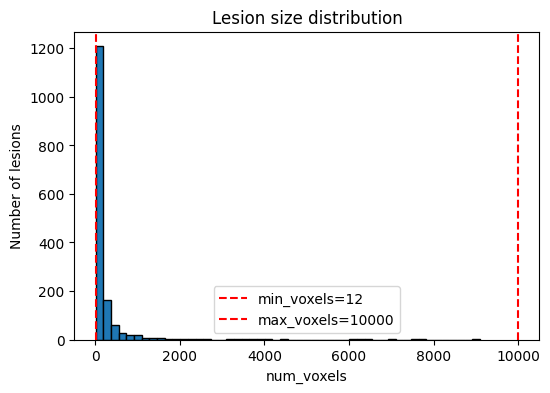

In [12]:
# Lesion‐size distribution
plt.figure(figsize=(6,4))
plt.hist(df["num_voxels"], bins=50, edgecolor="k")
plt.axvline(12, color="r", linestyle="--", label="min_voxels=12")
plt.axvline(10000, color="r", linestyle="--", label="max_voxels=10000")
plt.legend()
plt.xlabel("num_voxels")
plt.ylabel("Number of lesions")
plt.title("Lesion size distribution")
plt.show()